<a href="https://colab.research.google.com/github/E-girgen/Thesis-Data-Science-Society/blob/main/BERTje_Not_preprocessed_captions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive/"
%cd "/content/drive/MyDrive/Colab Notebooks"

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
data = pd.read_csv("cleaned_captions_np.csv")
 # Stel tab als scheidingsteken in


In [ ]:
nd= data.copy()

In [ ]:
#install packages
!pip install transformers
!pip install datasets
!pip install scikit-plot
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.7 MB/s eta 0:00:00


In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import InputExample, InputFeatures
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("GroNLP/bert-base-dutch-cased")


tokenizer_config.json:   0%|          | 0.00/254 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/608 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def process_data(row):
    text = row['Text']
    text = str(text)
    text = ' '.join(text.split())

    encodings = tokenizer(text, padding=True, truncation=True, max_length=128)

    emotion = row['Category']

    if emotion == 'joy':
        label = 0
    elif emotion == 'anger':
        label = 1
    elif emotion == 'sadness':
        label = 2
    elif emotion == 'neutral':
        label = 3
    elif emotion == 'fear':
        label = 4
    elif emotion == 'love':
        label = 5

    encodings['label'] = label
    encodings['text'] = text

    return encodings




In [ ]:
processed_data = []

for i in range(len(nd)):
    processed_data.append(process_data(nd.iloc[i]))
new_nd = pd.DataFrame(processed_data)

In [ ]:
from sklearn.model_selection import KFold
import pandas as pd
import pyarrow as pa
from datasets import Dataset

In [ ]:
from sklearn.model_selection import KFold
from transformers import AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from datasets import Dataset
from transformers import TrainingArguments, Trainer

# Definieer K-Fold
kf = KFold(n_splits=10, shuffle=True, random_state=2022)

# Loop over de 10 folds
for fold, (train_idx, valid_idx) in enumerate(kf.split(new_nd)):
    train_df, valid_df = new_nd.iloc[train_idx], new_nd.iloc[valid_idx]

    train_hg = Dataset.from_pandas(train_df)
    valid_hg = Dataset.from_pandas(valid_df)

    model = AutoModelForSequenceClassification.from_pretrained(
        "GroNLP/bert-base-dutch-cased",
        num_labels=6
    )

    model.config.hidden_size = 2048
    model.config.hidden_dropout_prob = 0.2
    model.config.max_position_embeddings = 64

    # Definieer de optimizer (AdamW) met de gespecificeerde leersnelheid
    optimizer = AdamW(model.parameters(), lr=5e-5)

    # Definieer de learning rate scheduler (ReduceLROnPlateau)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=len(train_hg) // 64 * 10)

    # Controleer of de kolomnamen overeenkomen met wat het model verwacht
    # Pas deze aan op basis van de uitvoer van je tokenizer (bijvoorbeeld 'input_ids', 'attention_mask', enz.)
    training_args = TrainingArguments(
        output_dir=f'./results/fold_{fold}',
        num_train_epochs=5,
        per_device_train_batch_size=64,
        per_device_eval_batch_size=128,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir=f'./logs/fold_{fold}',
        logging_steps=5,
        evaluation_strategy="epoch"
    )

    trainer_bertje = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_hg,
        eval_dataset=valid_hg,
        tokenizer=tokenizer
    )

    # Train het model
    trainer_bertje.train()

    # Optioneel: Voer evaluatie uit op een aparte testset of validerende set
    trainer_bertje.evaluate()

model.safetensors:   0%|          | 0.00/437M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.724800,1.670637
2,1.547400,1.508291
3,1.454400,1.453847
4,1.262400,1.364685
5,0.991700,1.259721


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.726900,1.689158
2,1.491200,1.612909
3,1.569400,1.514155
4,1.263500,1.421392
5,1.061800,1.432772


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.752900,1.670935
2,1.577500,1.561904
3,1.490300,1.471680
4,1.185200,1.332740
5,1.062900,1.289498


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.725700,1.703929
2,1.574400,1.639528
3,1.416400,1.538636
4,1.341000,1.453195
5,0.964100,1.443227


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.714300,1.661243
2,1.625900,1.543144
3,1.451900,1.497859
4,1.138100,1.331798
5,1.130800,1.296818


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.714900,1.650818
2,1.736600,1.582143
3,1.425300,1.464311
4,1.271400,1.331244
5,0.946200,1.225411


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.736100,1.730275
2,1.520500,1.699473
3,1.448200,1.612046
4,1.242500,1.495826
5,0.950200,1.447078


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.758800,1.657866
2,1.602100,1.536318
3,1.502100,1.470897
4,1.316000,1.387072
5,1.095100,1.242106


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.694600,1.702511
2,1.656200,1.637438
3,1.512600,1.523473
4,1.347700,1.408410
5,0.976000,1.271427


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base-dutch-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,1.676300,1.685935
2,1.577100,1.618378
3,1.440400,1.536953
4,1.218700,1.416084
5,0.983700,1.341919


In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertForSequenceClassification, BertTokenizer, TrainingArguments, Trainer

In [ ]:
trainer_bertje.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,1.754600,1.677088
2,1.529400,1.522223
3,1.546300,1.463657
4,1.370700,1.446638
5,1.221600,1.414937


TrainOutput(global_step=65, training_loss=1.4842970261206994, metrics={'train_runtime': 31.983, 'train_samples_per_second': 125.066, 'train_steps_per_second': 2.032, 'total_flos': 93374889152256.0, 'train_loss': 1.4842970261206994, 'epoch': 5.0})

In [ ]:
trainer_bertje.evaluate()

{'eval_loss': 1.3419190645217896,
 'eval_runtime': 0.1616,
 'eval_samples_per_second': 618.693,
 'eval_steps_per_second': 6.187,
 'epoch': 5.0}

In [ ]:
import numpy as np

# Make predictions
predictions = trainer_bertje.predict(valid_hg)

# Extract predicted labels from logits
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Access true labels from the validation dataset
true_labels = valid_hg['label']

# Now, you have both true_labels and predicted_labels


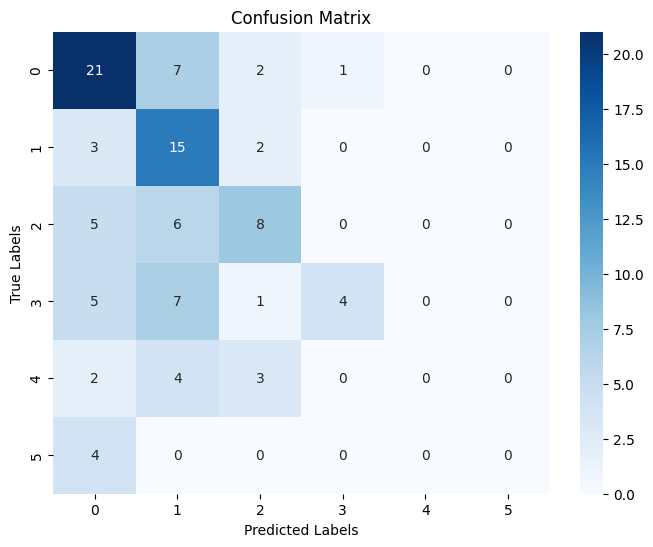

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1, 2, 3, 4, 5], yticklabels=[0, 1, 2, 3, 4, 5])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:

from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print(report)



              precision    recall  f1-score   support

           0       0.53      0.68      0.59        31
           1       0.38      0.75      0.51        20
           2       0.50      0.42      0.46        19
           3       0.80      0.24      0.36        17
           4       0.00      0.00      0.00         9
           5       0.00      0.00      0.00         4

    accuracy                           0.48       100
   macro avg       0.37      0.35      0.32       100
weighted avg       0.47      0.48      0.43       100



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# Calculate and print additional metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
f1 = f1_score(true_labels, predicted_labels, average='macro')

print(f"\nAccuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")


Accuracy: 0.48
Precision: 0.3682692307692308
Recall: 0.3472943506774526
F1-Score: 0.32013384880417584


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Extra